In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import codecs
import seaborn as sns
from mpl_toolkits.axisartist.axislines import SubplotZero
from scipy.optimize import curve_fit
from scipy import integrate
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker
%matplotlib inline

data_dir = "data/20221110 S-5Me decay/-7/vis/*.txt"

# temperature = 30
temperature = int(data_dir.split('/vis')[0].split("/")[-1])

result_dir = data_dir.split("*.txt")[0].replace("data", "result")
result_file_name = "_".join(data_dir.split("*.txt")[0].split("/")[1:-1])

paths = [p for p in glob.glob(data_dir)]
# 積分範囲の定義
integral_region = [400, 550]
x_1 = 1/(integral_region[0]*(10**(-7)))
x_2 = 1/(integral_region[1]*(10**(-7)))
result_dict = {}

apply_abs = lambda x: abs(x)
apply_str = lambda x: str(x)

for path in paths:
    # ファイル名  ex: -60 445.時系列
    file_name = path.split("/")[-1].split(".")[0]
    with codecs.open(path, "r", "UTF-8", "ignore") as file:
        col_names = ["c{0:02d}".format(i) for i in range(5)]
        df = pd.read_table(file, names=col_names)
        df = df.rename(
            columns={"c00": "wavelength", "c01": "photon count"}
        )
        df = df.drop(["c02", "c03", "c04"], axis=1)
#         波数のカラムを作る
        df["wavenumber"] = 1/((df["wavelength"])*(10**(-7)))
#         積分範囲の部分を取り出す
        df_target = df[df["wavenumber"] < x_1]
        df_target = df_target[df["wavenumber"] > x_2]
        x = df_target["wavenumber"]
        y = df_target["photon count"]
        integral_result = integrate.trapz(y, x)
        result_dict.update({file_name : integral_result})

        
result_df = pd.DataFrame.from_dict(result_dict, orient="index")
result_df = result_df.rename(
            columns={0: "light intensity"}
        )
result_df['light intensity'] = result_df['light intensity'].map(apply_abs)
result_df.sort_values("light intensity", ascending=False)

os.makedirs(result_dir, exist_ok=True)
result_df.to_csv(result_dir + result_file_name + ".csv", index=True)

<ipython-input-2-479b9c60fbce>:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_target = df_target[df["wavenumber"] > x_2]
<ipython-input-2-479b9c60fbce>:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_target = df_target[df["wavenumber"] > x_2]
<ipython-input-2-479b9c60fbce>:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_target = df_target[df["wavenumber"] > x_2]
<ipython-input-2-479b9c60fbce>:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_target = df_target[df["wavenumber"] > x_2]
<ipython-input-2-479b9c60fbce>:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_target = df_target[df["wavenumber"] > x_2]


In [3]:
# concat/のデータを用いてkp1, kp2, kt1, kt2を算出する
fit_data_dir = result_dir.split("vis")[0] + "fit_result/concat/"
fit_data = result_dir.split("vis")[0] + "fit_result/concat/result_df.csv"

# 可視光強度のラベルが同じ順番か確認
df_fit_data = pd.read_csv(fit_data)
print(df_fit_data, result_df)

  Unnamed: 0     opt_B     opt_C     opt_D       k_1       k_2  sorted_order
0    001 490 -0.003053 -4.849533 -0.017533  0.017533 -0.014536             0
1    010 490 -0.006084 -4.360976 -0.011261  0.011261 -0.009160             1
2    011 490 -0.004895 -4.187612 -0.005725  0.005725 -0.004621             2
3    100 490 -0.013680 -3.062131 -0.002813  0.002813 -0.002120             3
4    101 490  0.004339 -2.445981 -0.001530  0.001530 -0.001086             4      light intensity
001     1.456019e+08
010     9.837866e+07
011     4.542194e+07
100     2.337698e+07
101     1.084080e+07


[ 1.65844793e-04  7.85139147e-05  1.19178442e-02 -9.78361086e-03]


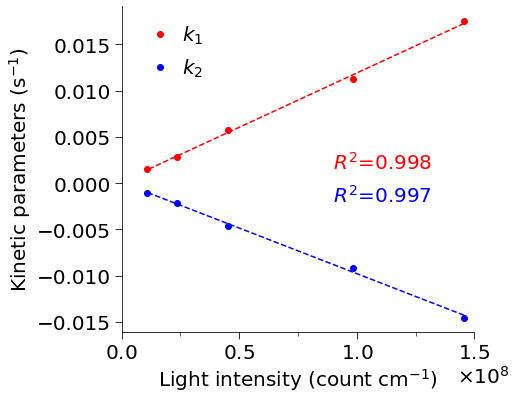

In [4]:
# グラフ表示
x_min = 0
x_max = 17.5
x_ticks = [0, 5*(10**7), 10*(10**7), 15*(10**7)]

df_fit_data["light intensity"] = result_df["light intensity"].values

# ラベルに10^7を表示するのでx軸を10^7で割る
x = df_fit_data["light intensity"]
y_1 = df_fit_data["k_1"]
y_2 = df_fit_data["k_2"]

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 20

#軸主目盛り線の長さ
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
#x軸補助目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 4

plt.rcParams["legend.frameon"] = False

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_xlabel('Light intensity (count $\mathrm{cm^{-1}}$)')
# ax.set_xlabel('Light intensity ($10^{7}$ count $\mathrm{cm^{-1}}$)')
ax.set_ylabel('Kinetic parameters ($\mathrm{s^{-1}}$)')

# 軸の最大値、最小値、表示メモリ設定
ax.set_xlim(x_min, x_max)
ax.set_xticks(x_ticks)

# x軸ラベルの下に空間を生成
# ax.get_xaxis().set_tick_params(pad=8)

# 目盛りを外に出す
ax.tick_params(direction='out')

# 2.5間隔で補助メモリ
ax.xaxis.set_minor_locator(ticker.MultipleLocator(25000000))

# ×10表記
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.get_xaxis().get_offset_text().set_position((1.1,0))

# 枠線の消去
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.2)
ax.plot(x, y_1, "o", color="red", lw='1', label="$k_1$")
ax.plot(x, y_2, "o", color="blue", lw='1', label="$k_2$")

def func(x, a, b):
    f = a*x + b
    return f

# k1のフィット
popt_1, pcov_1 = curve_fit(func,x,y_1)

residuals_1 =  y_1 - func(x, popt_1[0],popt_1[1])
rss_1 = np.sum(residuals_1**2)#residual sum of squares = rss
tss_1 = np.sum((y_1-np.mean(y_1))**2)#total sum of squares = tss
r_squared_1 = 1 - (rss_1 / tss_1)
ax.plot(x,func(x, popt_1[0],popt_1[1]),'--', color="red")

ax.annotate("$R^2$="+str(np.round(r_squared_1,3)), xy=(0.6, 0.5), xycoords='axes fraction', color='red')

# kt1, kp1の算出　光強度10^8のとき
k_t1 = popt_1[1]
k_p1 = func(10**8, popt_1[0],popt_1[1])

# k2のフィット
popt_2, pcov_2 = curve_fit(func,x,y_2)

residuals_2 =  y_2 - func(x, popt_2[0],popt_2[1])
rss_2 = np.sum(residuals_2**2)#residual sum of squares = rss
tss_2 = np.sum((y_2-np.mean(y_2))**2)#total sum of squares = tss
r_squared_2 = 1 - (rss_2 / tss_2)
ax.plot(x,func(x, popt_2[0],popt_2[1]),'--', color="blue")
ax.annotate("$R^2$="+str(np.round(r_squared_2,3)), xy=(0.6, 0.4), xycoords='axes fraction', color='blue')

# kt2, kp2の算出　光強度10^8のとき
k_t2 = popt_2[1]
k_p2 = func(10**8, popt_2[0], popt_2[1])

# 凡例表示
ax.legend(handletextpad=0.1)

parameters_list = np.array([k_t1, k_t2, k_p1, k_p2])
print(parameters_list)

In [5]:
# temp/kinetic_parametersにkt, kpを保存
df_parameters = pd.DataFrame(parameters_list.reshape(1,-1), index=[temperature], columns=["k_t1", "k_t2", "k_p1", "k_p2"])
df_parameters_dir = result_dir.split('vis')[0] + 'kinetic_parameters/'
os.makedirs(df_parameters_dir, exist_ok=True)
df_parameters.to_csv(df_parameters_dir + str(temperature) + "_parameters.csv", index=True)
fig.savefig(df_parameters_dir + str(temperature) + "_parameters.png")

print(parameters_list)

[ 1.65844793e-04  7.85139147e-05  1.19178442e-02 -9.78361086e-03]


# 110を消したいとき用 (未完成)

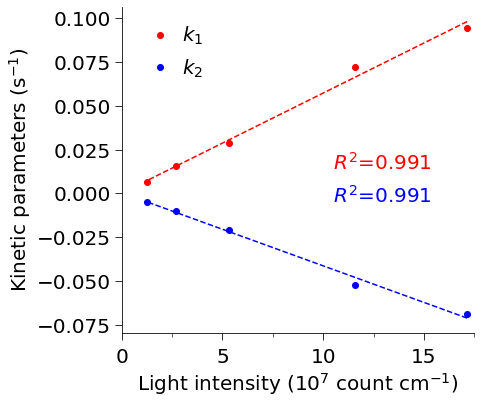

In [28]:
# 110を消したいとき

# グラフ表示
x_min = 0
x_max = 17.5
x_ticks = [0, 5, 10, 15]

df_fit_data["light intensity"] = result_df["light intensity"].values
df_fit_data = df_fit_data.drop(5, axis=0)

# ラベルに10^7を表示するのでx軸を10^7で割る
x = df_fit_data["light intensity"] / (10**7)
y_1 = df_fit_data["k_1"]
y_2 = df_fit_data["k_2"]

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 20

#軸主目盛り線の長さ
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
#x軸補助目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 4

plt.rcParams["legend.frameon"] = False

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_xlabel('Light intensity ($10^{7}$ count $\mathrm{cm^{-1}}$)')
ax.set_ylabel('Kinetic parameters ($\mathrm{s^{-1}}$)')

# 軸の最大値、最小値、表示メモリ設定
ax.set_xlim(x_min, x_max)
ax.set_xticks(x_ticks)

# x軸ラベルの下に空間を生成
ax.get_xaxis().set_tick_params(pad=8)

# 目盛りを外に出す
ax.tick_params(direction='out')

# 2.5間隔で補助メモリ
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2.5))

# 枠線の消去
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.2)
ax.plot(x, y_1, "o", color="red", lw='1', label="$k_1$")
ax.plot(x, y_2, "o", color="blue", lw='1', label="$k_2$")

def func(x, a, b):
    f = a*x + b
    return f

# k1のフィット
popt_1, pcov_1 = curve_fit(func,x,y_1)

residuals_1 =  y_1 - func(x, popt_1[0],popt_1[1])
rss_1 = np.sum(residuals_1**2)#residual sum of squares = rss
tss_1 = np.sum((y_1-np.mean(y_1))**2)#total sum of squares = tss
r_squared_1 = 1 - (rss_1 / tss_1)
ax.plot(x,func(x, popt_1[0],popt_1[1]),'--', color="red")

ax.annotate("$R^2$="+str(np.round(r_squared_1,3)), xy=(0.6, 0.5), xycoords='axes fraction', color='red')

# kt1, kp1の算出　光強度10^8のとき
k_t1 = popt_1[1]
k_p1 = func(10**8, popt_1[0],popt_1[1])

# k2のフィット
popt_2, pcov_2 = curve_fit(func,x,y_2)

residuals_2 =  y_2 - func(x, popt_2[0],popt_2[1])
rss_2 = np.sum(residuals_2**2)#residual sum of squares = rss
tss_2 = np.sum((y_2-np.mean(y_2))**2)#total sum of squares = tss
r_squared_2 = 1 - (rss_2 / tss_2)
ax.plot(x,func(x, popt_2[0],popt_2[1]),'--', color="blue")
ax.annotate("$R^2$="+str(np.round(r_squared_2,3)), xy=(0.6, 0.4), xycoords='axes fraction', color='blue')

# kt2, kp2の算出　光強度10^8のとき
k_t2 = popt_2[1]
k_p2 = func(10**8, popt_1[0],popt_2[1])

# 凡例表示
ax.legend(handletextpad=0.1)

parameters_list = np.array([k_t1, k_t2, k_p1, k_p2])

In [ ]:
# 積分範囲のグラフ
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_xlabel('Wavenumber (cm-1)')
ax.set_ylabel('Photon count')
fig.subplots_adjust(left=0.2)
ax.plot(df["wavenumber"], df["photon count"], color="red", lw='1')

ax.axvspan(x_1, x_2)